# INTRODUCTION TO JULIA

## Warning

+ Setting: Phd seminar in Prague 2011. MK talks about _FEniCS_. Wrongly, people fall asleep. __FEniCS is awesome__.
+ Setting: Phd seminar in Oslo 2016. MK talks about _Julia_. ???. __Julia is awesome__.

## SETUP

+ Ubuntu package from the repository
```
sudo add-apt-repository ppa:staticfloat/juliareleases
sudo add-apt-repository ppa:staticfloat/julia-deps
sudo apt-get update
sudo apt-get install julia
```
+ [Download](http://julialang.org/downloads/) Binaries (all platforms)
+ Build from source code
```
git clone https://github.com/JuliaLang/julia.git
cd julia
git checkout release-0.4  # unless you want the latest master
make -j 4
```
+ Try Julia in your browser via [JuliaBox](https://www.juliabox.org/). No installation but Google account required


## INTERACTION & SNEAK PEEK

Some modes of interacting with Julia:
+ REPL (go to terminal)
    - Julian mode, help mode(?), shell mode(;)
    - ! `edit`
+ text editor + command line
    - ! Hello world
+ Jupyter notebook
    - From inside Julia run `Pkg.add("IJulia")`. This gives you Julia kernel that the notebook can talk to
    - This is the notebok :)

In [ ]:
# Here is another feature - a built in package manager
installed_packages = Pkg.installed()
# len tab for autocomple
length(installed_packages)

In [ ]:
haskey(installed_packages, "IJulia")

In [ ]:
# Some unicode
a = 1:10;
1 ∈ a

In [ ]:
b = 4:20;
a ∩ b

In [ ]:
# Explore: Docstring contains the query
apropos("eigenvalues")

## WHAT IS IT?
+ Julia: A fresh approach to numerical computing, see [paper](http://arxiv.org/abs/1411.1607)
+ High level, dynamic, (dynamically) typed, general purpose language
+ Free and open-source. MIT licence
+ Went [viral](https://www.google.com/trends/explore#q=julia%20language) on Valentine's day 2014
+ Some features we will see in action today
    - type inference
    - JIT compiler
    - rich typestem
    - multiple dispatch
    - zero overhead C/Fortran calls (__CXX.jl__ offers some support for calling C++)
    - metaprogramming (only briefly)
+ An important feature missing today is _built in parallelism_

## WHY DO WE NEED YET ANOTHER LANGUAGE?

Short answer - to address the two language paradigm
+ Express the idea in high level language(Python) - setup prototype quickly. Performance far from production code
+ Production code then written in low level language (C/C++)
+ Write performance critical parts of code in low level language and glue together (Numba, SWIG)
    - FEniCS uses Python to generate C++ code that is compiled and wrapped for Python
    - Diako/Mikael prototype in Python/NumPy and then write the same code in Cython
+ To extend NumPy/SciPy you (usually) have to write C

Julia's approach
+ Designed to be easy to write with performance close to C
+ If that is true you need one language to solve your problem
+ It seems to be true

### Some benchmark problems of our own

### Project Euler problem 14. 
The following iterative sequence is defined for the set of positive integers:

+ n → n/2 (n is even)
+ n → 3n + 1 (n is odd)

Using the rule above and starting with 13, we generate the following sequence: 13 → 40 → 20 → 10 → 5 → 16 → 8 → 4 → 2 → 1. Which starting number, under one million, produces the longest chain? Note that whether the chain terminates for arbitrary $n$ is an unproved conjecture.

+ To solve PE problem's the solution must be obtained in less then 60s. Honor code is to beat 1s.
+ Note that the code presented here is not optimal. It is rather a brute force solution.
+ The answer it produces is correct

In [ ]:
"""Compute the Collatz chain for number n."""
function collatz_chain(n)
    k = 1
    while n > 1
        n = isodd(n) ? 3n+1 : n >> 1
        k += 1
        # println(n)
    end
    k
end

"""Which of the number [1, stop) has the longest Collatz chain."""
function solve_euler(stop)
    n, N, N_max = 1, 0, 0  
    while n < stop
        value = collatz_chain(n)
        if value > N_max
            N = n
            N_max = value
        end
        n += 1
    end
    (N, N_max)
end

In [ ]:
# Let's time it
N = 1000000
t0 = tic()
answer = solve_euler(N)
t1 = toc();
answer, t1

Julia is done in about 0.3s, Python need 12s. So with Julia I am onto the next problem. With Python it is back to the drawing board.

### Julia fractal
+ It is only approprate that we explore the Julia set
+ Explore points $z$ in the complex plain such that $z_{n+1}=z^2_{n}+c$ is bounded for any n

In [ ]:
# Julia code is a translation of the definition
"""Color Julia set. Code from https://www.youtube.com/watch?v=PsjANO10KgM"""
function julia(z, c)
    for n in 1:80
        if abs2(z) > 4
            return n-1
        end
        z = z*z + c
    end
    return 80
end

"""Color Julia set. Prealoc version"""
function julia(x, y, c)
    J = zeros(length(x), length(y))
    index = 0
    for r in y, i in x
        index += 1
        J[index] = julia(complex(r, i), c);
    end
    J
end

In [ ]:
# We explore a few points
cs = (complex(-0.06, 0.67), complex(0.279, 0), complex(-0.4, 0.6), complex(0.285, 0.01))

x = collect(1:-0.002:-1);
y = collect(-1.5:0.002:1.5);

Js = []
# Evaluate fractal generation
t0 = tic()
for c in cs
    push!(Js, [julia(complex(r, i), c) for i in x, r in y]);
    #push!(Js, julia(x, y, c));
end
t1 = toc()

@printf("Generated in %.4f s\n", t1);
println("Image size $(size(Js[1], 1))x$(size(Js[1], 2))")

In [ ]:
# Here we use python interopt(more on that later) to plot the fractals
using PyCall
@pyimport matplotlib.pyplot as plt

for J in Js
    plt.figure()
    plt.imshow(J, cmap="viridis", extent=[-1.5, 1.5, -1, 1])
end
plt.show()

About 4 seconds is required to make the fractals by list comprehensions. This is slower then Python which takes about 2.8. However the speed there comes from clever vectorization. And don't worry the code above can be made faster. If the image is prealocated and filled column by column, see `julia(x, y, c)`, the fractals are generated in 0.4s. Note that at this point we have two `julia` methods. Which one gets called when the code is run is our first encounter with _multiple dispatch_.

## WHEN IT READS LIKE PYTHON

+ Illustrate (not unrealistic) workflow by a made example of postprocessing 
+ Note that this is high-level: there are lambdas `x -> x + 1`, higher order functions, containers
+ No type declarations

In [ ]:
# Read the content on the directory and keep only the files
files = filter(isfile, readdir("."))

In [ ]:
# How many of the files are Julia files
n_jl_files = count(f -> endswith(f, ".jl"), files)
println("$(pwd()) contains $(n_jl_files) files.")

In [ ]:
# Get those files and print them
jl_files = files[find(f -> endswith(f, ".jl"), files)]
for (i, file) in enumerate(jl_files)
    println("Julia file $(file)")
end

In [ ]:
# We have seen Array container. Let's show Sets
jl_files2 = append!(jl_files, jl_files)
jl_set = Set(jl_files2)
println("$(pwd()) contains $(length(jl_set)) files.")

In [ ]:
# Reading from file. How many words in the MIT licence?
LICENCE = open("LICENSE")
content = lowercase(readall(LICENCE))
words = split(content, r"\W", keep=false)
close(LICENCE)
length(words)

In [ ]:
# We could have done this with bash. Show shell interopt
cmd = pipeline(`cat LICENSE`, `wc -w`)
run(cmd)  # 172 vs 171, less than 1% error is okay:)

In [ ]:
# Count them with multiplicity
unique = Dict()
for word in words
    unique[word] = get(unique, word, 0) + 1
end

In [ ]:
# Most common ones
for (k, v) in sort(collect(unique), by=last, rev=true)
    println("$(k) $(v)")
end

## SOME DIFFERENCES FROM PYTHON

A few examples where the behaviour from Python is different

In [ ]:
# : is => in the dictionary construction
dict = Dict(1 => "Miro", 2 => "Kuchta")

In [ ]:
# in checks for (key, value) pair
haskey(dict, 1), (1 => "Miro") ∈ dict

In [ ]:
# iteration is over (key, values) pairs
for (key, value) in dict
    println("$key => $value")
end

In [ ]:
# String concatenation is done with *. With + the operation should be commutative, which is not the case here
"Julia " * " Language"

In [ ]:
# / is for floating point division. Integer division is done by div
/(7, 4), div(7, 4)

In [ ]:
# Indexing starts at one. The last element in range is included. 0..last not included has same length as 1..last included
a = [1, 2, 3]
try
    a[0]
catch BoundsError
    println("No no, a[1]=", a[1], " ", a[end] == a[3] == 3)
end

collect(1:10)[10] == 10

In [ ]:
# complex numbers
complex(1, 1) == 1 + 1im

In [ ]:
# Convenience
x = 4
y = 2x  # no *
y == 8

In [ ]:
# More convenience. Save one "for"
[(i, j) for i in 1:4, j in "abcd"]

In [ ]:
# The arrays are column majored. In particular vector is a column vector
a = [1, 2, 3]

In [ ]:
# Contrast this with Python
A = reshape(collect(1:25), (5, 5))

In [ ]:
# In numpy you get to iterate over rows of matrix (for vectorization). In Julia this is not default. 
entries = [e for e in A]  #join(map(string, collect(A)), ", ")
# Moverover, columns are contiguous so accessing rows is not efficient.
# Finaly you iterate over values not pointers
for a in A
    a += 1
end
A

In [ ]:
# Column majored linear indexing
A[8] == 8

Now onto functions. Recall that you have already seen lambas `x -> 2x`

In [ ]:
# Multiline lambdas
map(f -> begin
    name, ext = splitext(f)
    uppercase(name)*uppercase(ext)^2
    end, readdir("."))

In [ ]:
# One lined named function definition
f(x, y) = 2x + 4y
f(1, 0) == 2

In [ ]:
# Implicit return statements
function f(name)
    if isequal(name, "Miro")
        return "slav"
    end
    "!"
end

(f("Miro"), f("You")) == ("slav", "!")

In [ ]:
# Variable positional arguments
mysum(args...) = join(map(string, args), "+")
mysum(10, 20)

In [ ]:
# Keyword arguments. Not a dictionary
function foo(args...; kwargs...)
    kwargs = Dict([k => v for (k, v) in kwargs])
    ans = join(map(string, args), "?")
    if haskey(kwargs, :x)  # Ignore :x for a while. It comes from the 'strange' kwargs array. Symbol
        ans = ans * "?" * string(kwargs[:x])
    end
    ans 
end
foo(10, 20, x=40)

## WHEN IT _IS_ PYTHON

+ Not entirely sure about giving up Python? What if you could use Julia with Python to make the transition easier?
+ The whole Python ecosystem can be reached via Pkg __PyCall__

In [ ]:
using PyCall

In [ ]:
# Let's load numpy and have it compute for us the eigenvalues of some matrix
@pyimport numpy.linalg as npla
A = diagm([1, 2, 3, 4])          # Julia matrix
eigv, eigw = npla.eig(A)         # Passed to python no copying
eigv                             # The result is Julia Array

In [ ]:
# Let's have numpy make the matrix and then Julia takes over for the actual work
@pyimport numpy as np
Apy = np.diag([1, 2, 3, 4])  # Note that this is Julia array passed to Numpy which comes back as a Julia matrix
eigvals(Apy)

In [ ]:
# Julia has native packages for plotting, but why give up matplotlib
@pyimport matplotlib.pyplot as plt

x = linspace(-1, 1, 100)
y = sin(2π*x)
plt.figure()
plt.plot(x, y)
plt.xlabel("\$x\$")  # Note that dollars have to be escaped for they have special role in Julia's string (interpolation)
plt.show()

Note that you can have a jupyter notebook running Python kernel, import Julia as a module and let the two languages play along nicely.

## WHEN IT _IS NOT_ PYTHON / REASONS FOR SPEED

Warning: I do not know/understand the whole story. It seems magical. That said, let me quote the Julia manual:

> Clever application of sufficiently advanced technology can be indistiguishable from magic (A. C. Clarke)

### JIT and type inference

In [ ]:
#Your code is parsed, type annotated(types can be inferred). 
simplef(x, y) = x+y
@code_warntype simplef(1, 2)   # Note x, y have types here

In [ ]:
# When f is called with specific values JIT compiles the function. With type annotation the compiler can reason about
# the code and generate efficient code.
@code_llvm simplef(1, 2)        # Note @julia_simplef_FOO(i64, i64)

In [ ]:
# If called with values of same type. We get a cached function
@code_llvm simplef(1, 2)        # Note @julia_simplef_FOO(i64, i64)

In [ ]:
# Different value types will invoke JIT again
@code_llvm simplef(1, 2.)        # @julia_simplef_BAR(i64, double)

### Type system
All values have types. You can type annotate your variables. This is not for performance. Rather, you declare your intensions better.

In [ ]:
map(typeof, (1, 2., [1, 2]))

In [ ]:
# This reads as is lhs an instance of rhs
1::Number, 1::Real, 1::Int

In [ ]:
# But 
try
    1::Int8
catch TypeError
    println("Type of 1 is $(typeof(1)) and that is not a subtype of Int8")
end

The type hierarchy is appearing.

In [ ]:
depth = 0
function printtypes(T)
    global depth
    if isleaftype(T)
        println("-"^(2*depth), "$T")
    else
        println("-"^depth, "$T")
        depth += 1
        map(printtypes, subtypes(T))
        depth -= 1
    end
end

printtypes(Real);

+ In the type tree the nodes are _abstract_ types and the leafs are _concrete_ types.
+ The abstract types express concepts and there are no instances of it but singletons. 
+ The concete types can have instances but cannot be subtyped.

### Multiple dispatch

If types are specified in the functions signature the compiler (first compiles and then) calls appropiate function based on the type of all the arguments. That is, unlike in OO programing, it is not the first type that owns the method. There is nothing special about the first argument; think `Int.__add__(self, other)` in Python. 

In [ ]:
# + is a function +(x, y) = ... . Which one is called based on args
@which 1+3

In [ ]:
@which 0x1+0x3

In [ ]:
@which 1+2.

New types can be defined easily.

In [2]:
"""Polynomial with value c[i]*sin(i*pi*x)"""
immutable SinePolynomial{T<:Real}
    coefs::Vector{T}
end

In [ ]:
# If not specified otherwise our parent is Any - the very tip of the type tree
super(SinePolynomial)

In [ ]:
# Our type is composite i.e. has fields
fieldnames(SinePolynomial)

To add 'its methods' we define functions with the new type. These are added to the dispatcher's system and called when needed.

In [3]:
import Base: +, -, call
# Add () for evaluating the polynomial
call{T}(p::SinePolynomial{T}, x::Real) = sum([c*sum(k*π*x) for (k, c) in enumerate(p.coefs)])

# We can add/subtract polynomials. This is simple because of othogonality
function +{T, S}(p::SinePolynomial{T}, q::SinePolynomial{S})
    np, nq = length(p.coefs), length(q.coefs)
    n = max(np, nq)
    p = [p.coefs; zeros(T, n-np)]
    q = [q.coefs; zeros(S, n-nq)]
    SinePolynomial(p+q)
end

function -{T, S}(p::SinePolynomial{T}, q::SinePolynomial{S})
    np, nq = length(p.coefs), length(q.coefs)
    n = max(np, nq)
    p = [p.coefs; zeros(T, n-np)]
    q = [q.coefs; zeros(S, n-nq)]
    SinePolynomial(p-q)
end

# See that + has been added to lookup table for dispatching
methods(+)

# 172 methods for generic function "+":
+(x::Bool) at bool.jl:33
+(x::Bool, y::Bool) at bool.jl:36
+(y::AbstractFloat, x::Bool) at bool.jl:46
+(x::Int64, y::Int64) at int.jl:8
+(x::Int8, y::Int8) at int.jl:16
+(x::UInt8, y::UInt8) at int.jl:16
+(x::Int16, y::Int16) at int.jl:16
+(x::UInt16, y::UInt16) at int.jl:16
+(x::Int32, y::Int32) at int.jl:16
+(x::UInt32, y::UInt32) at int.jl:16
+(x::UInt64, y::UInt64) at int.jl:16
+(x::Int128, y::Int128) at int.jl:16
+(x::UInt128, y::UInt128) at int.jl:16
+(x::Integer, y::Ptr{T}) at pointer.jl:77
+(x::Float32, y::Float32) at float.jl:207
+(x::Float64, y::Float64) at float.jl:208
+(z::Complex{T<:Real}, w::Complex{T<:Real}) at complex.jl:111
+(x::Bool, z::Complex{Bool}) at complex.jl:118
+(z::Complex{Bool}, x::Bool) at complex.jl:119
+(x::Bool, z::Complex{T<:Real}) at complex.jl:125
+(z::Complex{T<:Real}, x::Bool) at complex.jl:126
+(x::Real, z::Complex{Bool}) at complex.jl:132
+(z::Complex{Bool}, x::Real) at complex.jl:133
+(x::Real, z::Complex{T<:Real}) at complex.jl:144
+(z::Complex{T<:Real}, x::Real) at complex.jl:145
+(x::Rational{T<:Integer}, y::Rational{T<:Integer}) at rational.jl:179
+(x::Bool, A::AbstractArray{Bool,N}) at arraymath.jl:136
+(x::Integer, y::Char) at char.jl:43
+(a::Float16, b::Float16) at float16.jl:136
+(x::BigInt, y::BigInt) at gmp.jl:256
+(a::BigInt, b::BigInt, c::BigInt) at gmp.jl:279
+(a::BigInt, b::BigInt, c::BigInt, d::BigInt) at gmp.jl:285
+(a::BigInt, b::BigInt, c::BigInt, d::BigInt, e::BigInt) at gmp.jl:292
+(x::BigInt, c::Union{UInt16,UInt32,UInt64,UInt8}) at gmp.jl:304
+(c::Union{UInt16,UInt32,UInt64,UInt8}, x::BigInt) at gmp.jl:308
+(x::BigInt, c::Union{Int16,Int32,Int64,Int8}) at gmp.jl:320
+(c::Union{Int16,Int32,Int64,Int8}, x::BigInt) at gmp.jl:321
+(x::BigFloat, y::BigFloat) at mpfr.jl:208
+(x::BigFloat, c::Union{UInt16,UInt32,UInt64,UInt8}) at mpfr.jl:215
+(c::Union{UInt16,UInt32,UInt64,UInt8}, x::BigFloat) at mpfr.jl:219
+(x::BigFloat, c::Union{Int16,Int32,Int64,Int8}) at mpfr.jl:223
+(c::Union{Int16,Int32,Int64,Int8}, x::BigFloat) at mpfr.jl:227
+(x::BigFloat, c::Union{Float16,Float32,Float64}) at mpfr.jl:231
+(c::Union{Float16,Float32,Float64}, x::BigFloat) at mpfr.jl:235
+(x::BigFloat, c::BigInt) at mpfr.jl:239
+(c::BigInt, x::BigFloat) at mpfr.jl:243
+(a::BigFloat, b::BigFloat, c::BigFloat) at mpfr.jl:379
+(a::BigFloat, b::BigFloat, c::BigFloat, d::BigFloat) at mpfr.jl:385
+(a::BigFloat, b::BigFloat, c::BigFloat, d::BigFloat, e::BigFloat) at mpfr.jl:392
+(x::Irrational{sym}, y::Irrational{sym}) at irrationals.jl:72
+(x::Number) at operators.jl:73
+{T<:Number}(x::T<:Number, y::T<:Number) at promotion.jl:211
+{T<:AbstractFloat}(x::Bool, y::T<:AbstractFloat) at bool.jl:43
+(x::Number, y::Number) at promotion.jl:167
+(r1::OrdinalRange{T,S}, r2::OrdinalRange{T,S}) at operators.jl:330
+{T<:AbstractFloat}(r1::FloatRange{T<:AbstractFloat}, r2::FloatRange{T<:AbstractFloat}) at operators.jl:337
+{T<:AbstractFloat}(r1::LinSpace{T<:AbstractFloat}, r2::LinSpace{T<:AbstractFloat}) at operators.jl:356
+(r1::Union{FloatRange{T<:AbstractFloat},LinSpace{T<:AbstractFloat},OrdinalRange{T,S}}, r2::Union{FloatRange{T<:AbstractFloat},LinSpace{T<:AbstractFloat},OrdinalRange{T,S}}) at operators.jl:369
+(x::Ptr{T}, y::Integer) at pointer.jl:75
+{S,T}(A::Range{S}, B::Range{T}) at arraymath.jl:69
+{S,T}(A::Range{S}, B::AbstractArray{T,N}) at arraymath.jl:87
+(A::BitArray{N}, B::BitArray{N}) at bitarray.jl:834
+{T}(B::BitArray{2}, J::UniformScaling{T}) at linalg/uniformscaling.jl:28
+(A::Array{T,2}, B::Diagonal{T}) at linalg/special.jl:122
+(A::Array{T,2}, B::Bidiagonal{T}) at linalg/special.jl:122
+(A::Array{T,2}, B::Tridiagonal{T}) at linalg/special.jl:122
+(A::Array{T,2}, B::SymTridiagonal{T}) at linalg/special.jl:131
+(A::Array{T,2}, B::Base.LinAlg.AbstractTriangular{T,S<:AbstractArray{T,2}}) at linalg/special.jl:159
+(A::Array{T,N}, B::SparseMatrixCSC{Tv,Ti<:Integer}) at sparse/sparsematrix.jl:1019
+{P<:Union{Base.Dates.CompoundPeriod,Base.Dates.Period}}(x::Union{De

In [4]:
import Base.*
# We better prevent multiplications
*{T, S}(p::SinePolynomial{T}, q::SinePolynomial{S}) = throw(ArgumentError("No multiplication until CosinePolynomial"))

p = SinePolynomial([1, 2, 3])
q = SinePolynomial([2, -1])

try
    p*q
catch ArgumentError
    println("Is it okay? ", applicable(*, (typeof(p), typeof(q))))
    nothing
end

Is it okay? false


Suppose we want to vectorize the evaluation. In Python we could use _duck typing_ and see if the input supports iteration. Here we simply define new method.

In [5]:
Base.call{T}(p::SinePolynomial{T}, X) = [p(x) for x in X]

x = linspace(-1, 1, 100)
length(p(x))

100

In [6]:
@which p(x)         # See which one was celled

call{T}(p::SinePolynomial{T}, X) at In[5]:1

### Type stability
+ You do not have to talk about types when writing Julia code
+ Compiler does its best to remove uncertainties about types when analyzing the code but this is not always possible
+ The generated code must then handle the uncertainty, unboxing
+ Consider this example (taken from Introducing Julia and Julia manual)

In [ ]:
# Type INstability of s
function unstable(n)
    s = 0          # S is Float
    for i in 1:n
        s += s/i   # S is Float
    end
end

# Type stability of s
function stable(n)
    s = 0.0         # S is Float
    for i in 1:n
        s += s/i   # S is Float
    end
end

Let's compare the speed

In [ ]:
@time stable(1000000)

In [ ]:
@time unstable(1000000)

In [ ]:
println("The speed difference is huge ", 0.063284/0.000002, ". And so is the difference in the number of lines of generated code")

In [ ]:
# Run @code_warntype here as well to see the (un)certainty
@code_llvm stable(3)

In [ ]:
@code_llvm unstable(3)

### CALLING C

+ C functions available in shared libraries can be accessed via `ccall`
+ In this case Julia's JIT generates code such calling the C function from Julia is as fast as the call from native C
+ The arguments to `ccall` are function name, library, return type, tuple of input types and the values for input parameters

In [ ]:
# Example setenv via libc
function my_setenv(var::AbstractString, value::AbstractString)
    ccall((:setenv, "libc"), Cint, (Ptr{UInt8}, Ptr{UInt8}, Cint), var, value, 1)
end

In [ ]:
my_setenv("TODAY", "TUESDAY");

In [ ]:
# We will write getenv to check it
function my_getenv(var::AbstractString)
    bytestring(ccall((:getenv, "libc"), Ptr{UInt8}, (Ptr{UInt8}, ), var))
end

In [ ]:
my_getenv("TODAY")

In [ ]:
# Polynomial evaluation using GNU scientific library. Parametrized functions, restricted types
"""Evaluate polynomial c[1]*x^0 + c[2]*x^1 ... at x"""
function polyval{T<:Real, S<:Real}(c::Vector{T}, x::S)
    c = convert(Vector{Float64}, c)
    n = length(c)
    value = ccall((:gsl_poly_eval, "libgsl"), Cdouble, (Ptr{Cdouble}, Cint, Cdouble), c, n, x)
    Float64(value)
end

"""Vectorized version"""
function polyval{T, S}(c::Vector{T}, X::Vector{S})
    [polyval(c, x) for x in X]
end

In [ ]:
# Plot some random polynomials
using PyCall
@pyimport matplotlib.pyplot as plt

x = collect(linspace(-1, 1, 100)) # 1im will

plt.figure()
for i in 1:4
    c = rand(5)
    y = polyval(c, x)
    plt.plot(x, y)
end
plt.show()

### METAPROGRAMMING

Julia is _homoiconic_ - the code is representable as a data structure in the language. The structure can be manipulated.

In [7]:
# A basis building block is symbol
typeof(:x)

Symbol

In [1]:
# Symbols can be combined into expressions
f_def = quote
    cheer(name) = name * "!"
end

# Meta.show_sexpr(f_def)
# f_def
dump(f_def)

Expr 
  head: Symbol block
  args: Array(Any,(2,))
    1: LineNumberNode 
      file: Symbol In[1]
      line: Int64 3
    2: Expr 
      head: Symbol =
      args: Array(Any,(2,))
        1: Expr 
          head: Symbol call
          args: Array(Any,(2,))
          typ: Any
        2: Expr 
          head: Symbol block
          args: Array(Any,(2,))
          typ: Any
      typ: Any
  typ: Any


In [2]:
# And expression can be manipulated. Change the name to yell and !!
f_def.args[2].args[1].args[1] = :yell;
f_def.args[2].args[2].args[2].args[3] = "!!!";
f_def

quote  # In[1], line 3:
    yell(name) = begin  # In[1], line 3:
            name * "!!!"
        end
end

In [3]:
# Expressions can be evaluated. There will be no cheer.
eval(f_def);
isdefined(:cheer) 

false

In [4]:
# However we can yell
yell("Fire")

"Fire!!!"

The technique is useful when you need to generate a lot of boiler plate code. [Here's](https://github.com/JuliaLang/julia/blob/master/base/linalg/lapack.jl#L110) how Julia generates wrappers for some BLAS functions.

Next metaprogramming tools are _macros_. Using macros a customized code block can be included into a body of some existing code before its execution. Macros are denoted by @. We've already seen @time, @assert, @code_llvm.

In [5]:
# When is macro run?
macro makeuppercase(f)   
    println("I was called.")
    return Expr(:call, :uppercase, f)
end

# When the code is parsed the macro executes and changes body of f 
function transform(text::AbstractString)
    @makeuppercase text
end

I was called.


transform (generic function with 1 method)

In [6]:
# It does not exacute when the function is run.
transform("ApuhuAs")

"APUHUAS"

Here is a more impressive [example](https://github.com/JuliaLang/julia/blob/master/base/special/erf.jl) from the standard library which computes the inverse of the error function. The idea is that based on the values of argument different polynomial approximation is used. The polynomials are evaluated using Horner's rule and using [macro](https://github.com/JuliaLang/julia/blob/master/base/math.jl#L57) the code for the polynomial evaluation is inlined.

In [7]:
# We try to write the same code but evaluation of the polynomial will be done via call to external routine.
function _horner(x, p...)
    c = p[end]
    for i in length(p)-1:-1:1
        c = p[i] + c*x
    end
    c
end

function _erfinv(x::Float64)
    a = abs(x)
    if a >= 1.0
        if x == 1.0
            return Inf
        elseif x == -1.0
            return -Inf
        end
        throw(DomainError())
    elseif a <= 0.75 # Table 17 in Blair et al.
        t = x*x - 0.5625
        return x * _horner(t, 0.16030_49558_44066_229311e2,
                             -0.90784_95926_29603_26650e2,
                              0.18644_91486_16209_87391e3,
                             -0.16900_14273_46423_82420e3,
                              0.65454_66284_79448_7048e2,
                             -0.86421_30115_87247_794e1,
                              0.17605_87821_39059_0) /
                   _horner(t, 0.14780_64707_15138_316110e2,
                             -0.91374_16702_42603_13936e2,
                              0.21015_79048_62053_17714e3,
                             -0.22210_25412_18551_32366e3,
                              0.10760_45391_60551_23830e3,
                             -0.20601_07303_28265_443e2,
                              0.1e1)
    elseif a <= 0.9375 # Table 37 in Blair et al.
        t = x*x - 0.87890625
        return x * _horner(t, -0.15238_92634_40726_128e-1,
                               0.34445_56924_13612_5216,
                              -0.29344_39867_25424_78687e1,
                               0.11763_50570_52178_27302e2,
                              -0.22655_29282_31011_04193e2,
                               0.19121_33439_65803_30163e2,
                              -0.54789_27619_59831_8769e1,
                               0.23751_66890_24448) /
                   _horner(t, -0.10846_51696_02059_954e-1,
                               0.26106_28885_84307_8511,
                              -0.24068_31810_43937_57995e1,
                               0.10695_12997_33870_14469e2,
                              -0.23716_71552_15965_81025e2,
                               0.24640_15894_39172_84883e2,
                              -0.10014_37634_97830_70835e2,
                               0.1e1)
    else # Table 57 in Blair et al.
        t = 1.0 / sqrt(-log(1.0 - a))
        return _horner(t, 0.10501_31152_37334_38116e-3,
                          0.10532_61131_42333_38164_25e-1,
                          0.26987_80273_62432_83544_516,
                          0.23268_69578_89196_90806_414e1,
                          0.71678_54794_91079_96810_001e1,
                          0.85475_61182_21678_27825_185e1,
                          0.68738_08807_35438_39802_913e1,
                          0.36270_02483_09587_08930_02e1,
                          0.88606_27392_96515_46814_9) /
              (copysign(t, x) *
               _horner(t, 0.10501_26668_70303_37690e-3,
                          0.10532_86230_09333_27531_11e-1,
                          0.27019_86237_37515_54845_553,
                          0.23501_43639_79702_53259_123e1,
                          0.76078_02878_58012_77064_351e1,
                          0.11181_58610_40569_07827_3451e2,
                          0.11948_78791_84353_96667_8438e2,
                          0.81922_40974_72699_07893_913e1,
                          0.40993_87907_63680_15361_45e1,
                          0.1e1))
    end
end

_erfinv (generic function with 1 method)

In [8]:
# Make sure it works
erfinv(0.002) - _erfinv(0.002)

0.0

In [10]:
# Is there a difference in performance?
@time [erfinv(x) for x in -1:0.00001:1];

  0.008254 seconds (2 allocations: 1.526 MB)


In [12]:
# _erfinv is about 2x slower. Note the difference in memory
@time [_erfinv(x) for x in -1:0.00001:1];

  0.017964 seconds (800.00 k allocations: 13.733 MB, 9.73% gc time)


Final technique we will illustrate is _staged programming_. Using _@generated_ with function definition we can generate code based on the type of arguments. We work with type annotated AST. 

In [13]:
# We make the polynomial degree available to the type system
"x^n"
type Monomial{n}
end

In [14]:
# We generate code based on n
@generated function evaluate{n}(::Monomial{n}, x::Real)
    println("I was called")
    coefs = zeros(Real, n+1)
    coefs[n+1] = 1
    quote
        return Base.Math.@horner x $(coefs...)
    end
end

evaluate (generic function with 1 method)

In [15]:
p = Monomial{2}()
evaluate(p, 1.0)  # Print message

I was called


1.0

In [16]:
evaluate(p, 2.0)  # No message

4.0

In [17]:
evaluate(Monomial{4}(), 3.0)  # New type -> message

I was called


81.0

## BATTERIES INCLUDED

+ Julia has a very large scientific stack, e.g. FFT (FFTW by Steven G. Johnson), LA(LAPACK, BLAS, SuiteSparse), statistics
+ Native plotting, e.g. _Gadfly_ package
+ You can use Python modules(`PyCall`), existing C/Fortran libraries(`ccall`)
+ Opportunity to write missing packages!

In [19]:
using PyCall
@pyimport scipy.fftpack as pyfft
# Show that FFT works
v = rand(20)

fft_jl = FFTW.r2r(v, [FFTW.REDFT10])
fft_py = pyfft.dct(v)

norm(fft_jl - fft_py)

1.6184142622847343e-15

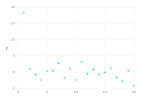

In [20]:
# Native plotting with Gadfly
using Gadfly
plot(y=fft_jl)

In [21]:
# Linear algebra. The favourite Poisson problem on UnitInterval. Convergence of CG1 FEM
A = 0  # Keep A outside for loop
for ncells in [2^i for i in 8:14]
    h = 1/ncells
    x = Float64[h*i for i in 0:ncells]
    F = sin(2π*x)
    U = sin(2π*x)/4/π^2
    
    # Based on type of A specialized solver will be called
    A = SymTridiagonal(fill(2, ncells+1), fill(-1, ncells))/h
    b = h*F

    u = A\b
    e = norm(u - U)
    println(e)
end

# Which factorize was dispatched
@which factorize(A)

0.0

factorize(S::SymTridiagonal{T}) at linalg/ldlt.jl:46

05742739384431261
0.00406087309076182
0.002871496220147093
0.0020304589269507247
0.0014357520673215604
0.0010152301641646005
0.0007178761457711251


In [22]:
# And now the eigenvalues. Convergence of the smallest eig of -u'' = lambda* u in (0, 1) with homog. Dirichlet bcs
for ncells in [2^i for i in 3:11]
    h = 1/ncells
    x = Float64[h*i for i in 0:ncells]

    A = SymTridiagonal(fill(2, ncells+1), fill(-1, ncells))/h
    M = SymTridiagonal([1.; fill(4h/6, ncells-1); 1.], fill(h/6, ncells))
    
    eigw, eigv = eig(full(A), full(M))                          # Dense
    # eigw = first(eigs(sparse(A), sparse(M), nev=6, which=:SM))  # Sparse

    lmin = minimum(eigw)
    println("System size $(length(eigw)), error in λ=$(abs(lmin-π^2))")
end

System size 9, error in λ=5.396945915394443
System size 17, error in λ=3.094555556451626
System size 33, error in λ=1.4650779232335207
System size 65, error in λ=0.6797474241796966
System size 129, error in λ=0.32442205306690397
System size 257, error in λ=0.1582254302874535
System size 513, error in λ=0.07811004502728203
System size 1025, error in λ=0.03880408264532953
System size 2049, error in λ=0.01933930544917395


## Conclusions
+ If you spend a few hours browsing the standard library including the growing number of packages and find out that all you need is available then I highly recommend picking up the language.
+ Note that new libraries, even if they are _just_ rewrites of old code, can be buggy. Bad - you don't notice the bug. Good - you fix it and become a contributor.

## ADDITIONAL RESOURCES

+ Wikibook [__Introducing Julia__](https://en.wikibooks.org/wiki/Introducing_Julia)  
+ [__Julia manual__](http://docs.julialang.org/en/release-0.4/) from the homepage
+ YouTube videos
    - Introduction [Steven Johnson](https://www.youtube.com/watch?v=jhlVHoeB05A) @ EuroScipy
    - Introduction [Alan Edelman](https://www.youtube.com/watch?v=37L1OMk_3FU) @ MIT
    - Some metaprogramming [Jeff Bezanson, Stefan Karpinski](https://www.youtube.com/watch?v=pZTqMSM2ksY) @ Curry On
    - Julia + Python [Stefan Karpinksi](https://www.youtube.com/watch?v=PsjANO10KgM) @ PyDATA
    - ... and plenty others from [JuliaCon](http://juliacon.org/). See Julia's [YouTube](https://www.youtube.com/user/JuliaLanguage/videos) channel.
+ Blog posts (mostly metaprogramming)
    - [John Myles White](http://www.johnmyleswhite.com/notebook/category/julia/)
    - [Gray Calhoun](http://gray.clhn.org/blog/julia-macros/)
+ Source code on [GitHub](https://github.com/JuliaLang/julia)